In [47]:
!pip install einops

In [4]:
import pandas as pd
import numpy as np
import torch
import torchvision
import os
import cv2
import einops

GPU_NUM = 0 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
os.environ['CUDA_LAUNCH_BLOCKING']="1"
print(device)
print(f'torch version : {torch.__version__}')
torch.cuda.empty_cache()

cuda:0
torch version : 1.12.1


In [5]:
print(os.getcwd())
train_list = pd.read_csv('./data/train.csv')
print(len(train_list))
print(train_list[:3])


/home/seunmul/dacon/ISR
1640
                    LR                   HR
0  ./train/lr/0000.png  ./train/hr/0000.png
1  ./train/lr/0001.png  ./train/hr/0001.png
2  ./train/lr/0002.png  ./train/hr/0002.png


512 크기의 이미지를 64 크기로 분할
2048 크기의 이미지를 256 크기로 분할

In [6]:
def make_patch_image(path,mode='train'):
    path_list = pd.read_csv(path)
    LR_csv = []
    
    for p in path_list['LR']:
        img_path = './data'+p[1:]
        lr_img = cv2.imread(img_path)
        lr_img = einops.rearrange(lr_img, '(h p1) (w p2) c -> (h w) p1 p2 c', p1=64,p2=64)
        for i in range(len(lr_img)):
            new_path = p[:-4]+'_'+str(i)+'.png'
            LR_csv.append(new_path)
            cv2.imwrite('./data'+new_path[1:],lr_img[i])
    data = {'LR':LR_csv}

    if mode =='train':
        HR_csv = []
        for p in path_list['HR']:
            img_path = './data'+p[1:]
            hr_img = cv2.imread(img_path)
            hr_img = einops.rearrange(hr_img, '(h p1) (w p2) c -> (h w) p1 p2 c', p1=256,p2=256)
  
            for i in range(len(hr_img)):
                new_path = p[:-4]+'_'+str(i)+'.png'
                HR_csv.append(new_path)
                cv2.imwrite('./data'+new_path[1:],hr_img[i])
        data['HR'] = HR_csv
    
    data = pd.DataFrame(data)
    new_path = path[:-4]+'_patch.csv'
    data.to_csv(new_path)
    
    return new_path

In [8]:
#new_csv = make_patch_image('./data/train.csv')

In [9]:
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

In [21]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, img_list, transform=None, train_mode=True):
        self.transform = transform
        self.train_mode = train_mode
        self.low_list = img_list['LR']
        if self.train_mode:
            self.high_list = img_list['HR']

    def __getitem__(self,index,check=False):
        n = random.randrange(64)
        low_path = './data'+self.low_list.iloc[index][1:-4]+'_'+str(n)+'.png'
        low_img = cv2.imread(low_path)

        if check:
            print(f'image path : {low_path}')
            print(f'image shape : {low_img.shape}')
        
        if self.transform is not None:
            low_img=self.transform(low_img)

        
        if self.train_mode:
            high_path = './data'+self.high_list.iloc[index][1:-4]+'_'+str(n)+'.png'
            high_img = cv2.imread(high_path)
            if self.transform is not None:
                high_img = self.transform(high_img)
            return low_img, high_img
        else:
            file_name = low_path.split('/')[-1]
                
            return low_img, file_name
    
    def __len__(self):
        return len(self.low_list)

image path : ./data/train/lr/0000_13.png
image shape : (64, 64, 3)
(64, 64, 3) (256, 256, 3)


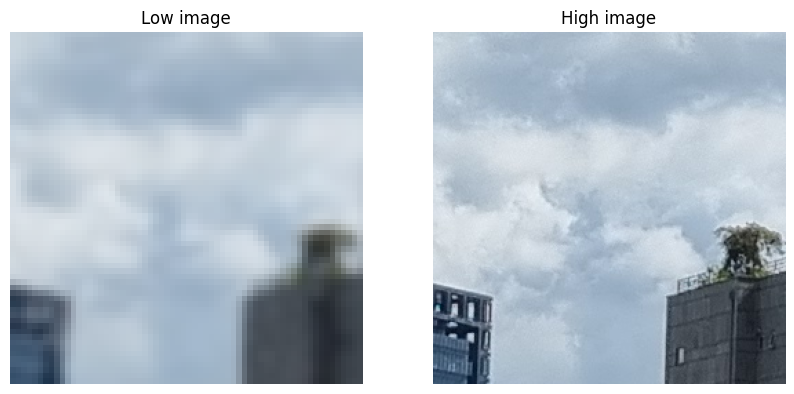

In [23]:
import matplotlib.pyplot as plt
train_list = pd.read_csv('./data/train.csv')
temp_dataset = CustomDataset(train_list)
low, high = temp_dataset.__getitem__(0,check=True)
print(low.shape, high.shape)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(low[...,::-1])
plt.axis('off')
plt.title('Low image')

plt.subplot(1,2,2)
plt.imshow(high[...,::-1])
plt.axis('off')
plt.title('High image')
plt.show()

In [28]:
BATCH_SIZE =16
IMG_SIZE=512

In [33]:
from torch.utils.data import DataLoader

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    #torchvision.transforms.RandomHorizontalFlip(),
    #torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.ToTensor(),
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.ToTensor(),
])

In [34]:
train_list = pd.read_csv('./data/train.csv')
train_list = train_list[0:int(len(train_list)*0.75)]
val_list = train_list[int(len(train_list)*0.75):]
print(f'train data : {len(train_list)}, val data : {len(val_list)}')

train_dataset = CustomDataset(train_list,train_transform,train_mode=True)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
    )

val_dataset = CustomDataset(val_list,test_transform,train_mode=True)
val_loader = torch.utils.data.DataLoader(val_dataset,BATCH_SIZE,False)


test_list = pd.read_csv('./data/test.csv')
print(f'test data : {len(test_list)}')
test_dataset = CustomDataset(test_list,test_transform,train_mode=False)
test_loader = DataLoader(test_dataset,BATCH_SIZE,False)

train data : 1230, val data : 308
test data : 18


torch.Size([16, 3, 64, 64]) torch.Size([16, 3, 256, 256])


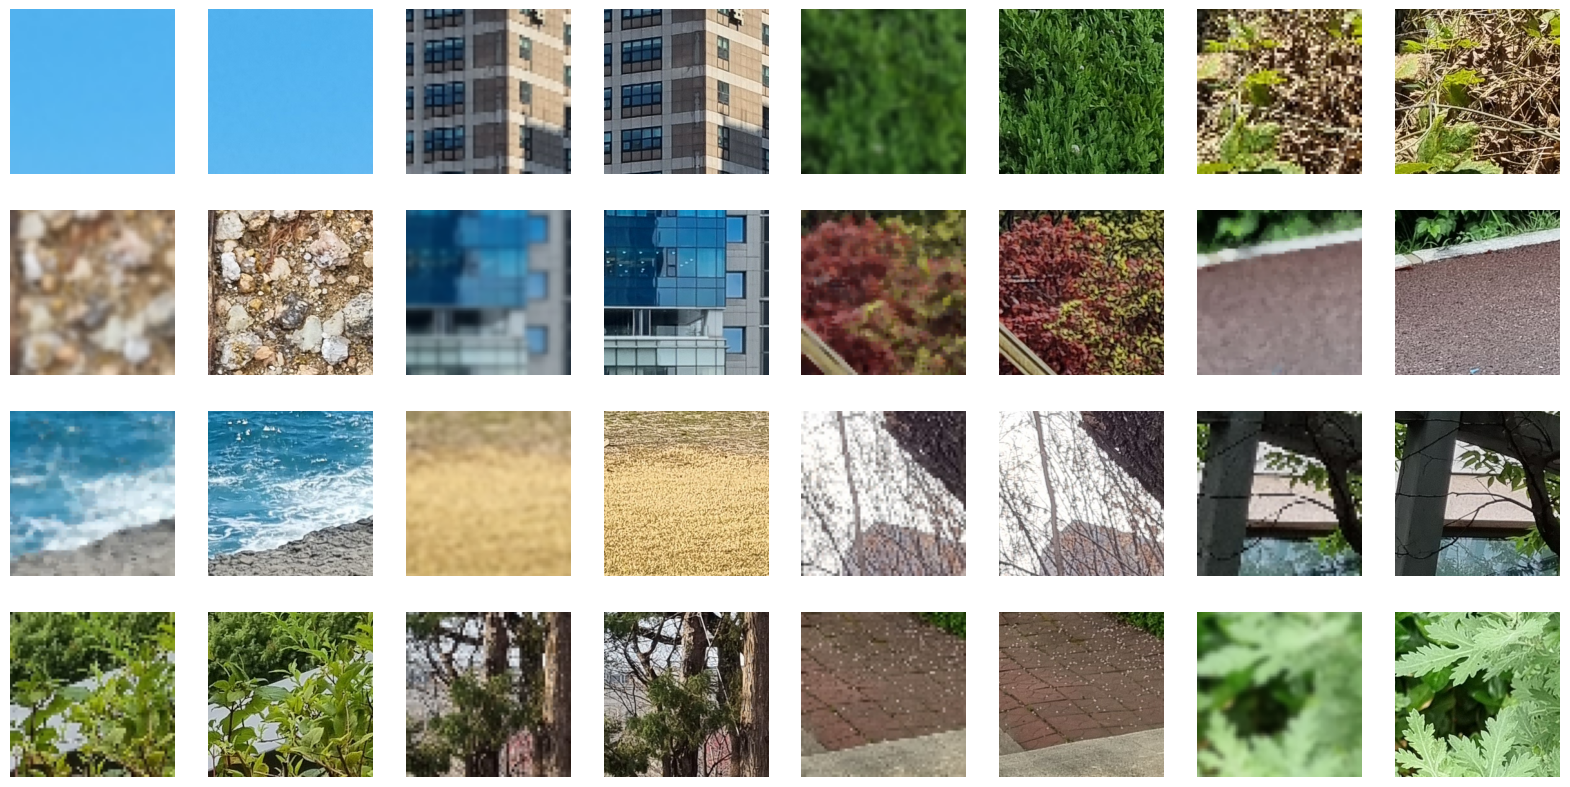

In [35]:
low, high = next(iter(train_loader))

print(low.shape, high.shape)

plt.figure(figsize=(20,10))
for i in range(BATCH_SIZE):
    plt.subplot(4,8,2*i+1)
    plt.imshow(low[i].detach().cpu().numpy().transpose(1,2,0)[...,::-1])
    plt.axis('off')
    plt.subplot(4,8,2*(i+1))
    plt.imshow(high[i].detach().cpu().numpy().transpose(1,2,0)[...,::-1])
    plt.axis('off')


In [91]:
# low, high = next(iter(train_loader))
# print(f'low image shape including batch : {low.shape}')

# PATCH_SIZE = 64
# # Reshape back
# origin = einops.rearrange(low, '(h w) c p1 p2 ->c (h p1) (w p2)',h=512//PATCH_SIZE, w=512//PATCH_SIZE)
# print(f'Reshape back shape : {origin.shape}')

# plt.figure(figsize=(10,10))
# plt.imshow(origin.detach().cpu().numpy().transpose(1,2,0)[...,::-1])
# plt.axis('off')
# plt.title('Reshape back Low image')
# plt.show()

In [92]:
from torch import nn
from einops.layers.torch import Rearrange

class MeanShift(nn.Module):
    def __init__(self, mean_rgb, sub):
        super(MeanShift, self).__init__()

        sign = -1 if sub else 1
        r = mean_rgb[0] * sign
        g = mean_rgb[1] * sign
        b = mean_rgb[2] * sign

        self.shifter = nn.Conv2d(3, 3, 1, 1, 0)
        self.shifter.weight.data = torch.eye(3).view(3, 3, 1, 1)
        self.shifter.bias.data   = torch.Tensor([r, g, b])

        # Freeze the mean shift layer
        for params in self.shifter.parameters():
            params.requires_grad = False

    def forward(self, x):
        x = self.shifter(x)
        return x

class ResBlock(nn.Module):
    def __init__(self, n_feats, res_scale=0.1):
        super(ResBlock, self).__init__()
        m = []
        for i in range(2):
            m.append(nn.Conv2d(n_feats, n_feats, kernel_size=3,bias=True, padding=3//2))
            if i == 0:
                m.append(nn.ReLU(True))
        self.act = nn.ReLU(True)
        self.conv1 = nn.Conv2d(n_feats, n_feats,kernel_size =3 , padding =1)
        self.conv2 = nn.Conv2d(n_feats, n_feats,kernel_size =3 , padding =1)
        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        res = self.conv1(x)
        res = self.act(res)
        res = self.conv2(res).mul(self.res_scale)
        res += x
        return res

class EDSR(nn.Module):
    def __init__(self, scale_factor=2*2, num_channels=3, num_feats=256, num_blocks=32, res_scale=0.1):
        super(EDSR, self).__init__()

        self.sub_mean = MeanShift((0.4488, 0.4371, 0.4040), sub=True)
        self.add_mean = MeanShift((0.4488, 0.4371, 0.4040), sub=False)

        self.head = nn.Conv2d(num_channels, num_feats, kernel_size=3,bias=True, padding=3//2)
        body = [ResBlock(num_feats, res_scale) for _ in range(num_blocks)]
        self.body = nn.Sequential(*body)
        self.tail = nn.Sequential(
            nn.Conv2d(num_feats, num_feats * (2**2), kernel_size=3, stride=1, padding=1), 
            nn.PixelShuffle(2),
            nn.ReLU(),
            nn.Conv2d(num_feats, num_feats * (2**2), kernel_size=3, stride=1, padding=1), 
            nn.PixelShuffle(2),
            nn.ReLU(),
            nn.Conv2d(num_feats, num_channels, kernel_size=3, stride=1, padding=1),
        )
    
    def forward(self, x):
        x = self.sub_mean(x)
        x = self.head(x)
        res = self.body(x)
        res += x
        x = self.tail(res)
        x = self.add_mean(x)

        return x

In [93]:
import torchsummary
model = EDSR()

torchsummary.summary(model,(3,64,64),device='cpu')
print('# parameters:', sum(param.numel() for param in model.parameters()))
print('model set')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 64, 64]              12
         MeanShift-2            [-1, 3, 64, 64]               0
            Conv2d-3          [-1, 256, 64, 64]           7,168
            Conv2d-4          [-1, 256, 64, 64]         590,080
              ReLU-5          [-1, 256, 64, 64]               0
            Conv2d-6          [-1, 256, 64, 64]         590,080
          ResBlock-7          [-1, 256, 64, 64]               0
            Conv2d-8          [-1, 256, 64, 64]         590,080
              ReLU-9          [-1, 256, 64, 64]               0
           Conv2d-10          [-1, 256, 64, 64]         590,080
         ResBlock-11          [-1, 256, 64, 64]               0
           Conv2d-12          [-1, 256, 64, 64]         590,080
             ReLU-13          [-1, 256, 64, 64]               0
           Conv2d-14          [-1, 256,

In [95]:
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(params=model.parameters(), lr =0.00007)

scheduler = None
print('parameter set')

parameter set


In [96]:
import math
def cal_psnr(img1,img2):
    x = img1.detach().cpu().numpy()
    y = img2.detach().cpu().numpy()
    PIXEL_MAX = 1.0
    # # input shaep가 [ num_patch, 3, 64, 64] 일경우
    p = 0
    for i in range(img1.shape[0]):
        #PSNR구하는 코드
        p += 10 * math.log10(PIXEL_MAX / np.mean((x[i] - y[i]) ** 2) )
    return p/img1.shape[0]

    # input shape가 [3, 64, 64] 일 경우
    # return 10 * math.log10(PIXEL_MAX / np.mean((x - y) ** 2) )

In [97]:
from tqdm import tqdm

history = {'loss':[],'train_psnr':[],'val_psnr':[]}
best_psnr = 0.0
count =1
EPOCH = 200

print('start train')
torch.cuda.empty_cache()
model.to(device)
print(torch.cuda.memory_allocated() / 1024 /1024)
for epoch in range(1, EPOCH+1):
    running_loss = 0
    train_psnr = 0

    model.train()
    for lr, hr in tqdm(iter(train_loader)):
        # lr.shape [1,512//64 * 512//64 , 3, 64,64]
        lr_img = lr.to(device)
        hr_img = hr.to(device)

        optimizer.zero_grad()
        out = model(lr_img)
        loss = criterion(out,hr_img)
        train_psnr += cal_psnr(out,hr_img)

        loss.backward()
        optimizer.step()
        running_loss +=loss.item()

    train_psnr = round(train_psnr/len(train_loader),5)
    print(f'{epoch} Train Loss : {running_loss/len(train_loader):5f}, Train PSNR : {train_psnr}')
    
    # val data
    model.eval()
    psnr = 0
    with torch.no_grad():
        for lr, hr in tqdm(iter(val_loader)):
            val_lr = lr.to(device)
            val_hr = hr.to(device)
            sr = model(val_lr)
            psnr += cal_psnr(sr,val_hr)
        
    psnr = round(psnr/len(val_loader),5)
    print(f'Val psnr : {psnr}')

    history['loss'].append(running_loss)
    history['train_psnr'].append(train_psnr)
    history['val_psnr'].append(psnr)

    if best_psnr < psnr:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            },f'./checkpoint/best_EDSR_{psnr}.pth')
        print('Model Saved')
        best_psnr = psnr
        count = 1
    else:
        if count > 5:
            print('Early Stopping')
            break
        count +=1
    

start train
306.18896484375


 33%|███▎      | 1629/4920 [13:52<28:01,  1.96it/s]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(range(len(history['train_psnr'])),history['train_psnr'],'g--',label='train_psnr')
plt.plot(range(len(history['train_psnr'])),history['val_psnr'],'b--',label='val_psnr')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.legend()
plt.show()


In [ ]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    pred_img_list = []
    name_list = []
    with torch.no_grad():
        for lr_img, file_name in tqdm(iter(test_loader)):
            lr_img = lr_img.float().to(device)
            
            pred_hr_img = model(lr_img)
            
            for pred, name in zip(pred_hr_img, file_name):
                pred = pred.cpu().clone().detach().numpy()
                pred = pred.transpose(1, 2, 0)
                pred = pred*255.
                
                pred_img_list.append(pred.astype('uint8'))
                name_list.append(name)
    return pred_img_list, name_list

In [ ]:
#pred_img_list, pred_name_list = inference(model, test_loader, device)

In [ ]:
import zipfile
os.makedirs('./submission', exist_ok=True)
os.chdir("./submission/")
sub_imgs = []
for path, pred_img in tqdm(zip(pred_name_list, pred_img_list)):
    cv2.imwrite(path, pred_img)
    sub_imgs.append(path)
submission = zipfile.ZipFile("../submission.zip", 'w')
for path in sub_imgs:
    submission.write(path)
submission.close()
print('Done.')